In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error


from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
import numpy as np

from datetime import datetime



In [2]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [3]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.index=pd.to_datetime(df.index)

In [6]:
df.head()

,CS_HPA_20_cities,CS_HP,UNEMPLOY,LF_Part,Y10_CMT,Y30_fixed_mortgage_rate,UNEMPLOY_adj,LF_Part_adj,year,month
Date,,,,,,,,,,
2000-01-01,100.589697,100.552,4.5,67.3,6.661000,8.2100,4.5,67.3,2000,Jan
2000-02-01,101.692479,101.339,4.4,67.3,6.519500,8.3250,4.4,67.3,2000,Feb
2000-03-01,102.783829,102.127,4.3,67.3,6.256522,8.2400,4.3,67.3,2000,Mar
2000-04-01,103.996444,102.922,3.7,67.3,5.990526,8.1525,3.7,67.3,2000,Apr
2000-05-01,105.252818,103.677,3.8,67.1,6.440455,8.5150,3.8,67.1,2000,May


In [7]:
target_index ='UNEMPLOY_adj'

In [8]:
index_title ='Unemployment Rate adj'

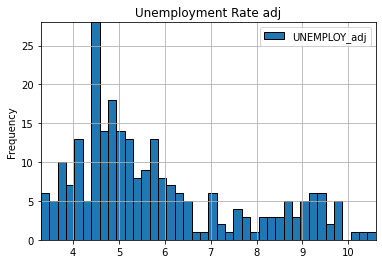

In [9]:
df.plot.hist(y=target_index,grid=True,bins=40,edgecolor='k',title=index_title).autoscale(enable=True,axis='both',tight=True)
plt.show()

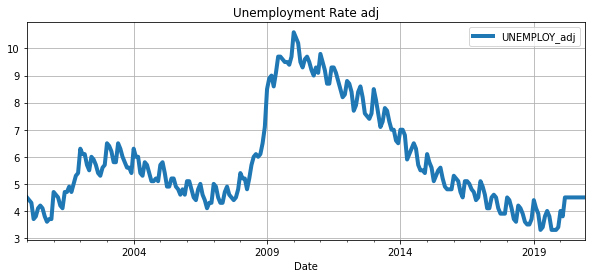

In [10]:
df.plot.line(y=target_index, figsize=(10,4),lw=4, grid=True, title=index_title)
plt.show()

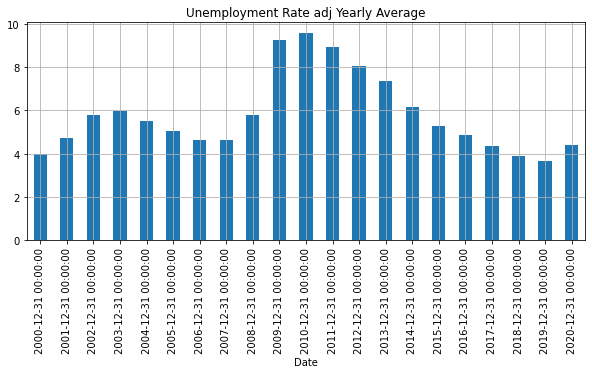

In [11]:
df[target_index].resample('A').mean().plot.bar(figsize=(10,4),grid=True, title=index_title + ' Yearly Average')
plt.show()

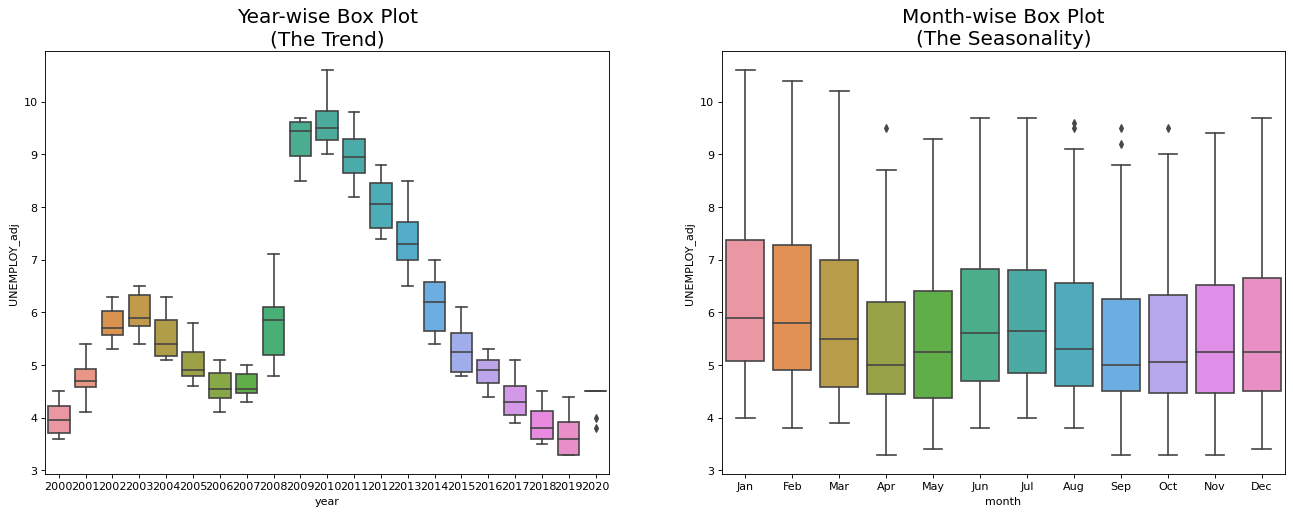

In [12]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=target_index, data=df, ax=axes[0])
sns.boxplot(x='month', y=target_index, data=df.loc[~df.year.isin([2000]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

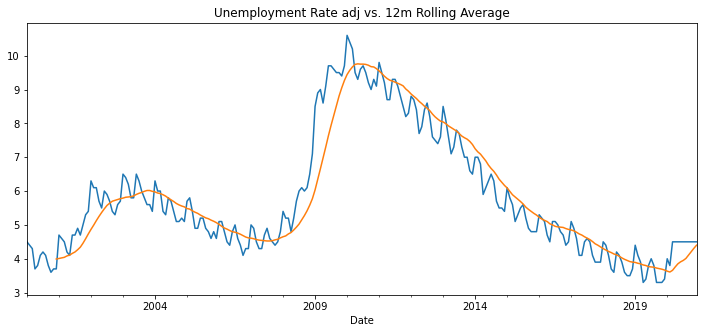

In [13]:
df[target_index].plot(figsize=(12,5))
df[target_index].rolling(window=12).mean().plot(title=index_title + ' vs. 12m Rolling Average')
plt.show()

In [14]:
cycle, trend = hpfilter(df[target_index], lamb=129600)

In [15]:
df['Trend']=trend

In [16]:
df['Cycle']=cycle

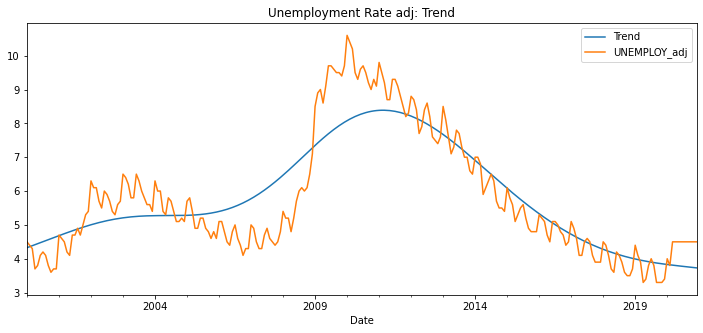

In [17]:
df[['Trend',target_index]].plot(figsize=(12,5),title=index_title + ': Trend')
plt.show()

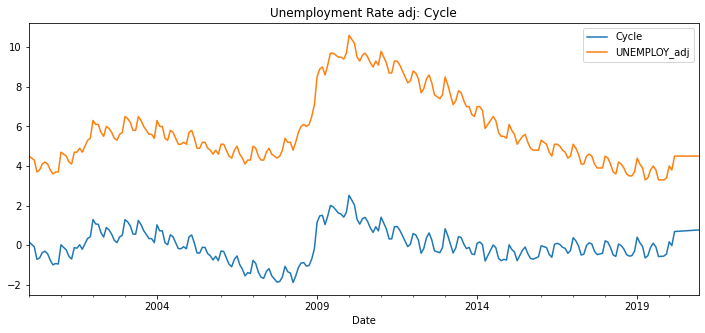

In [18]:
df[['Cycle',target_index]].plot(figsize=(12,5),title=index_title + ': Cycle')
plt.show()

In [19]:
#ETS

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,12

In [21]:
result_additive = seasonal_decompose(df[target_index], model = 'additive')

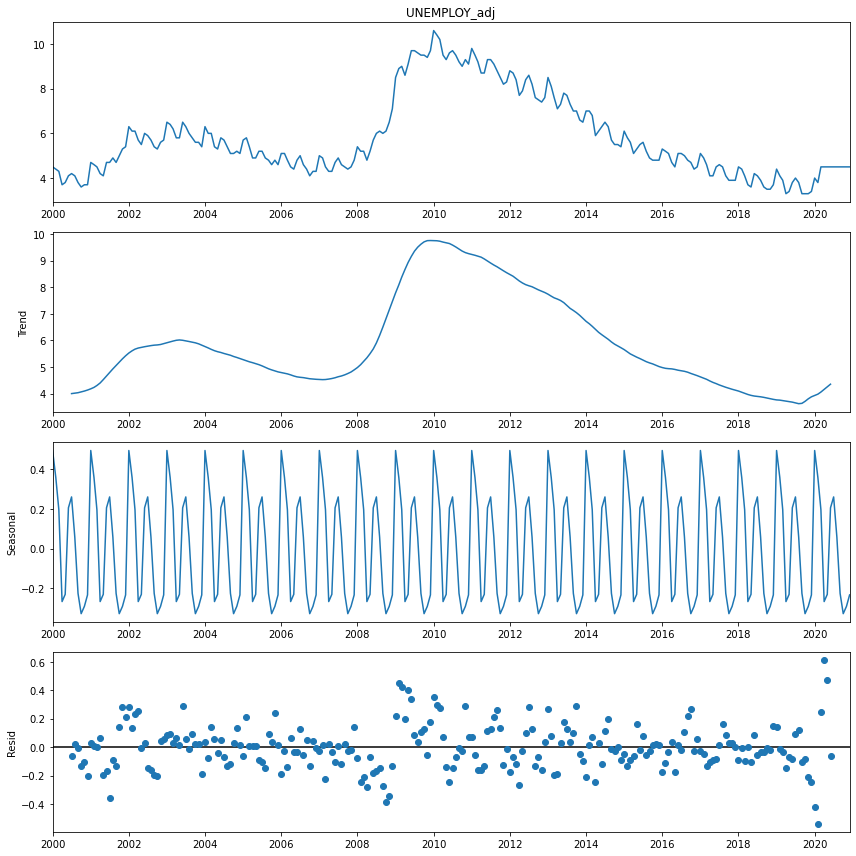

In [22]:
result_additive.plot();

In [23]:
result_multiplicative = seasonal_decompose(df[target_index], model = 'multiplicative')

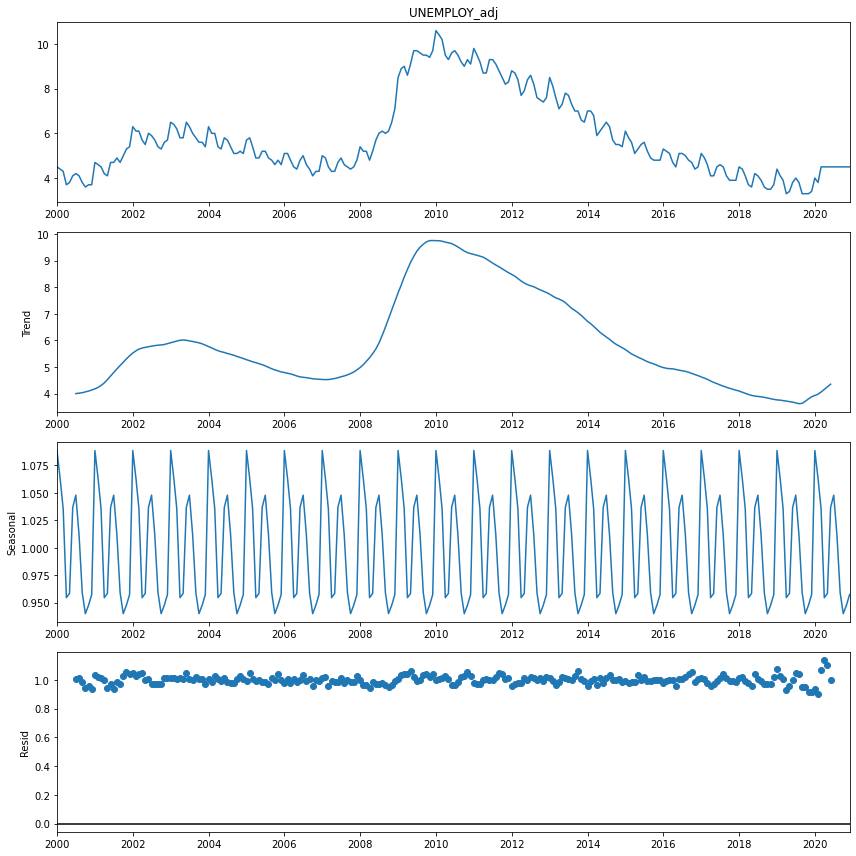

In [24]:
result_multiplicative.plot();

In [25]:
#EWMA

In [26]:
df['6-month--SMA']=df[target_index].rolling(window=6).mean()

In [27]:
df['12-month--SMA']=df[target_index].rolling(window=12).mean()

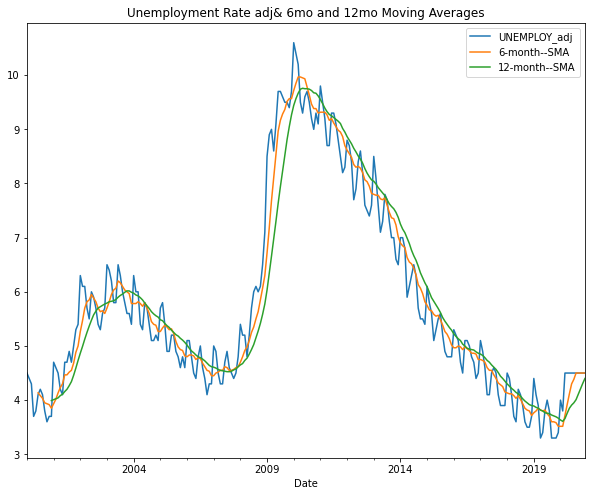

In [28]:
df[[target_index,'6-month--SMA','12-month--SMA']].plot(figsize=(10,8),title=index_title + '& 6mo and 12mo Moving Averages')
plt.show()

In [29]:
df['EWMA-12']=df[target_index].ewm(span=12, adjust=True).mean()

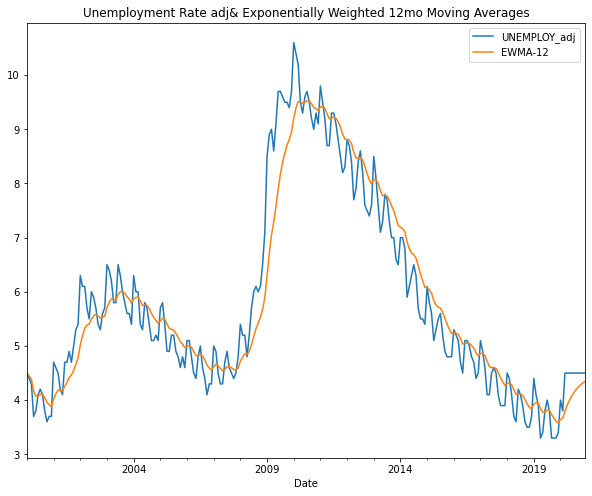

In [30]:
df[[target_index,'EWMA-12']].plot(figsize=(10,8),title=index_title + '& Exponentially Weighted 12mo Moving Averages')
plt.show()

In [31]:
#Holt-Winters method

In [32]:
df.index.freq= 'MS'

In [33]:
span = 12
alpha = 2/(span+1)

In [34]:
model = SimpleExpSmoothing(df[target_index])

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
fitted_model=model.fit(smoothing_level=alpha, optimized = False)

In [36]:
df['SES12']=fitted_model.fittedvalues.shift(-1)

In [37]:
model =  ExponentialSmoothing(df[target_index],trend='add')

In [38]:
fitted_model = model.fit()

In [39]:
df['DES_add_12']=fitted_model.fittedvalues.shift(-1)

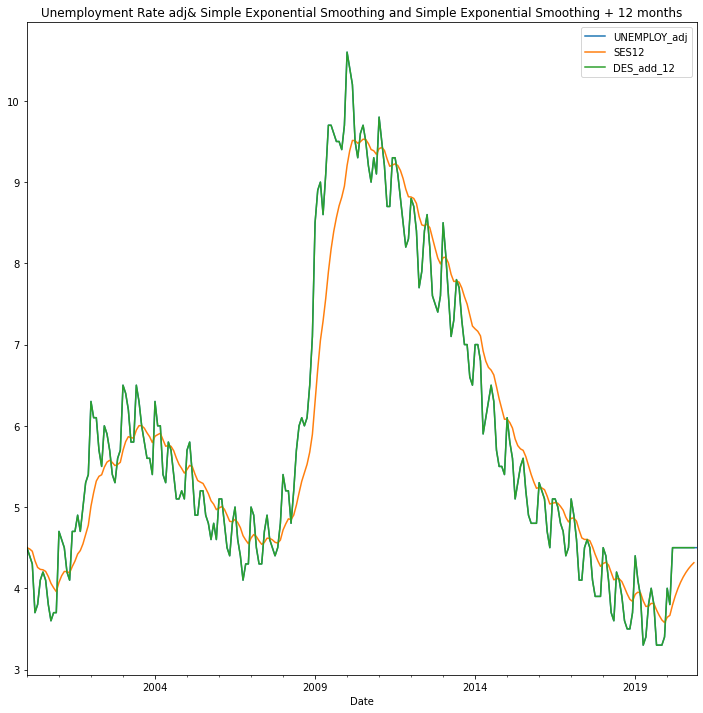

In [40]:
df[[target_index, 'SES12','DES_add_12']].plot(title=index_title + '& Simple Exponential Smoothing and Simple Exponential Smoothing + 12 months')
plt.show()

In [41]:
model =  ExponentialSmoothing(df[target_index],trend='add',seasonal='add', seasonal_periods=12)

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [42]:
fitted_model = model.fit()

In [43]:
df['TES_mul_12']=fitted_model.fittedvalues.shift(-1)

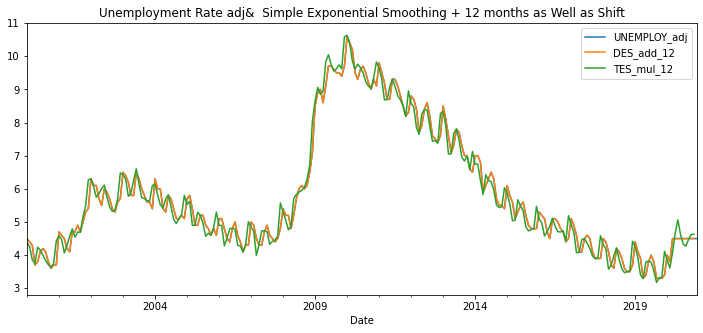

In [44]:
df[[target_index,'DES_add_12','TES_mul_12']].plot(figsize=(12,5),title=index_title + '&  Simple Exponential Smoothing + 12 months as Well as Shift')
plt.show()

In [45]:
df.drop(labels=['Trend','Cycle','6-month--SMA','12-month--SMA','EWMA-12','SES12','DES_add_12','TES_mul_12'],axis=1, inplace=True)

In [46]:
train_data=df.iloc[:201]
test_data=df.iloc[200:]

In [47]:
fitted_model=ExponentialSmoothing(train_data[target_index],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [48]:
test_predictions=fitted_model.forecast(52)

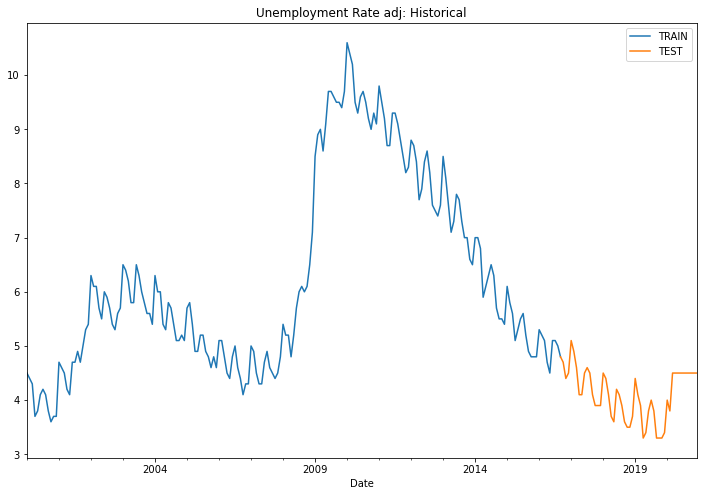

In [49]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Historical')
test_data[target_index].plot(legend=True, label='TEST')
plt.show()

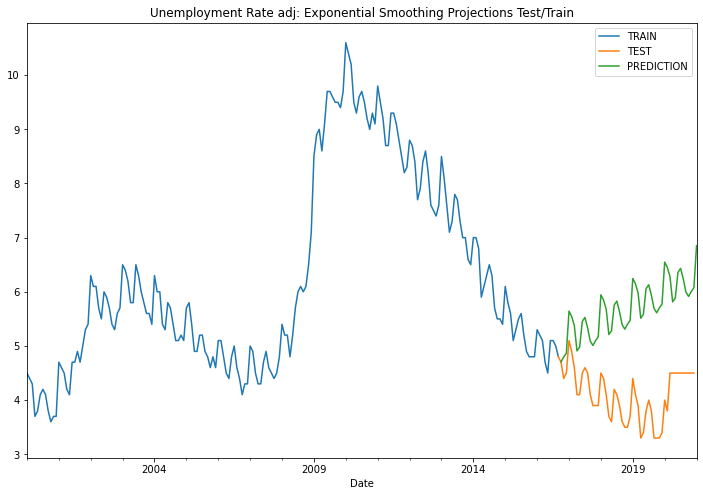

In [50]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Test/Train')
test_data[target_index].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

In [51]:
## Evaulation

In [52]:
mean_absolute_error(test_data[target_index],test_predictions)

1.566876827425577

In [53]:
mean_squared_error(test_data[target_index],test_predictions)

2.9339741068358833

In [54]:
np.sqrt(mean_squared_error(test_data[target_index],test_predictions))

1.7128847325012513

In [55]:
final_model=ExponentialSmoothing(df[target_index], 
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [56]:
forecast_predictions=final_model.forecast(36)

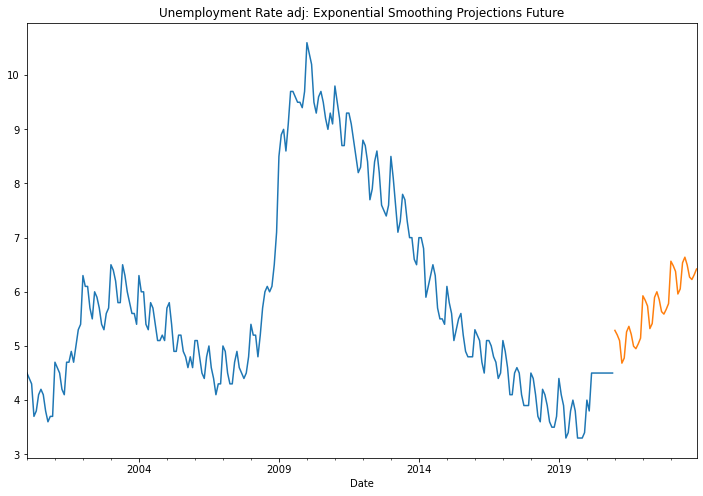

In [57]:
df[target_index].plot(figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Future')
forecast_predictions.plot()
plt.show()

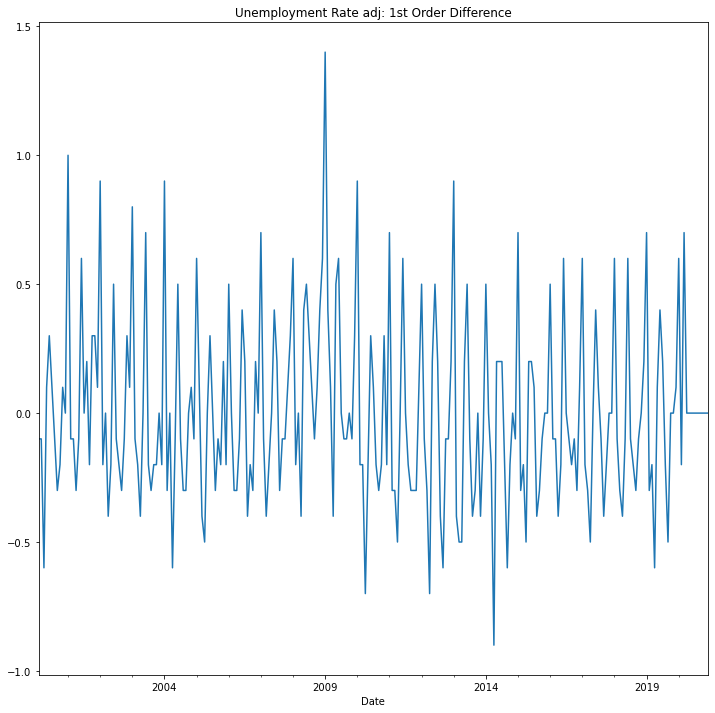

In [58]:
diff(df[target_index],k_diff=1).plot(title=index_title + ': 1st Order Difference')
plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
#acf(df[target_index])

In [61]:
#pacf_yw(df[target_index], nlags=252, method='mle')

In [62]:
#pacf_ols(df[target_index], nlags=251)

In [63]:
from pandas.plotting import lag_plot

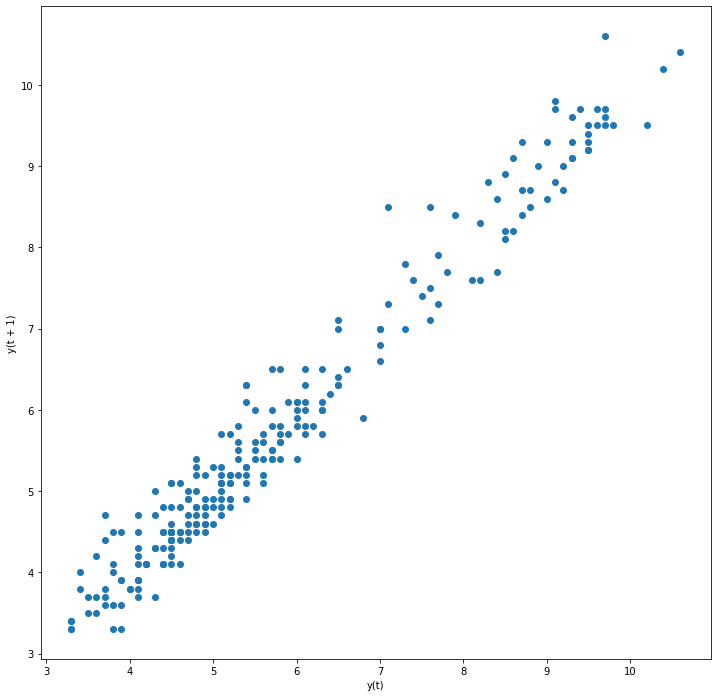

In [64]:
lag_plot(df[target_index])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

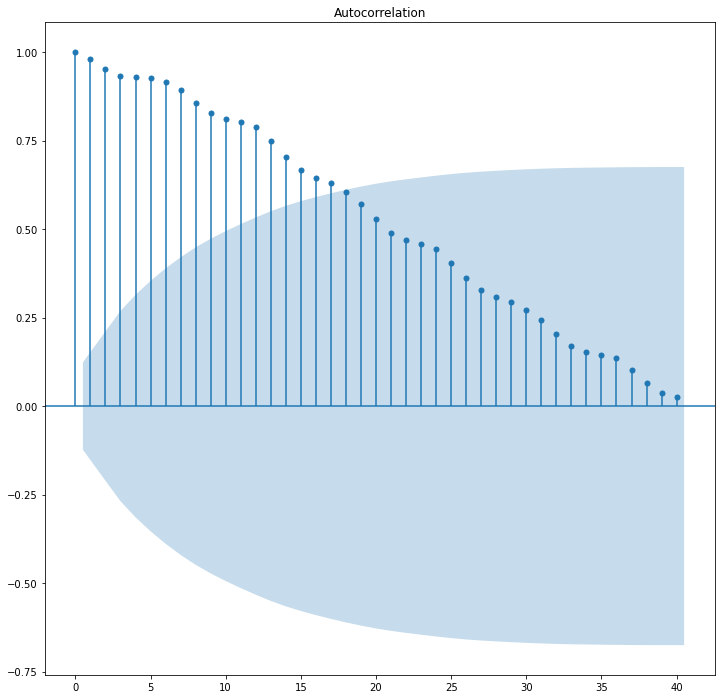

In [66]:
plot_acf(df[target_index],lags=40)
plt.show()

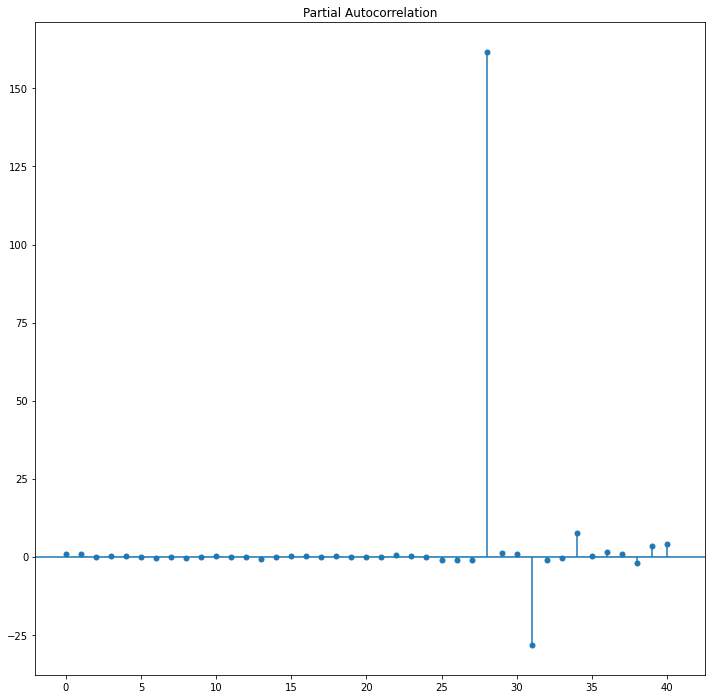

In [67]:
plot_pacf(df[target_index],lags=40)
plt.show()

In [68]:
#AR model

In [69]:
from statsmodels.tsa.ar_model import AR, ARResults

In [70]:
train =df.iloc[:200]

In [71]:
test =df.iloc[200:]

In [72]:
model = AR(train[target_index])

In [73]:
AR1fit = model.fit(maxlag=1)

In [74]:
AR1fit.aic

-2.0110699728011854

In [75]:
AR1fit.k_ar

1

In [76]:
AR1fit.params

const              0.140322
L1.UNEMPLOY_adj    0.977973
dtype: float64

In [77]:
start=len(train)

In [78]:
end=len(train)+len(test)-1

In [79]:
#AR1fit.predict(start=start, end=end)

In [80]:
predictions1 = AR1fit.predict(start=start, end=end)

In [81]:
predictions1 = predictions1.rename('AR{1} Predictions')

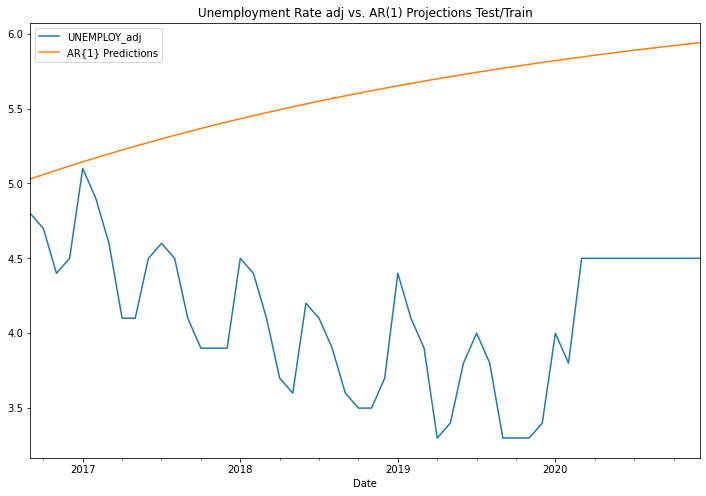

In [82]:
test[target_index].plot(figsize=(12,8),legend=True, title=index_title + ' vs. AR(1) Projections Test/Train')
predictions1.plot(legend=True);

In [83]:
model = AR(train[target_index])

In [84]:
AR2fit = model.fit(maxlag=2)

In [85]:
AR2fit.params

const              0.161451
L1.UNEMPLOY_adj    1.124894
L2.UNEMPLOY_adj   -0.150253
dtype: float64

In [86]:
predictions2 = AR2fit.predict(start=start, end=end)

In [87]:
predictions2 = predictions2.rename('AR{2} Predictions')

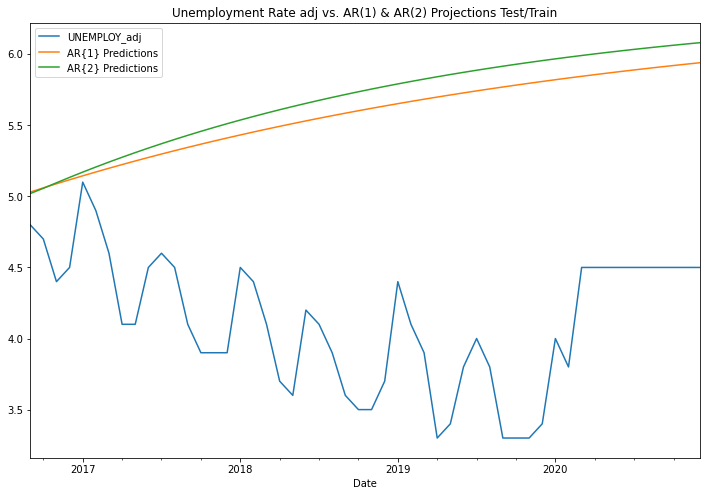

In [88]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1) & AR(2) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True);

In [89]:
model = AR(train[target_index])

In [90]:
ARfit = model.fit(ic='t-stat')

In [91]:
ARfit.params

const               0.187810
L1.UNEMPLOY_adj     1.001834
L2.UNEMPLOY_adj     0.036177
L3.UNEMPLOY_adj    -0.150305
L4.UNEMPLOY_adj     0.149966
L5.UNEMPLOY_adj     0.167609
L6.UNEMPLOY_adj    -0.258235
L7.UNEMPLOY_adj     0.095085
L8.UNEMPLOY_adj     0.020482
L9.UNEMPLOY_adj    -0.231541
L10.UNEMPLOY_adj    0.072460
L11.UNEMPLOY_adj    0.087252
L12.UNEMPLOY_adj    0.587729
L13.UNEMPLOY_adj   -0.608241
dtype: float64

In [92]:
predictions13=ARfit.predict(start,end)

In [93]:
predictions13=predictions13.rename('AR(13) Predictions')

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
labels = ['AR1','AR2','AR13']

In [96]:
preds = [predictions1,predictions2,predictions13]

In [97]:
for i in range(3):
    error = np.sqrt(mean_squared_error(test[target_index], preds[i]))
    print(f' {labels[i]} RMSE was: {error}')

 AR1 RMSE was: 1.569216626135902
 AR2 RMSE was: 1.6857523685005582
 AR13 RMSE was: 2.0713163534146073


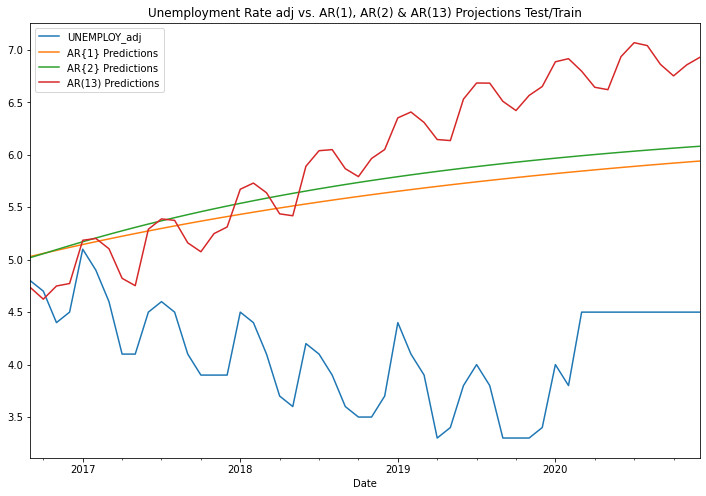

In [98]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1), AR(2) & AR(13) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions13.plot(legend=True);

In [99]:
#Forecasting

In [100]:
model=AR(df[target_index])

In [101]:
ARfit = model.fit(maxlag=13)

In [102]:
forcasted_values=ARfit.predict(start=len(df), end= len(df)+36).rename('Forecast')

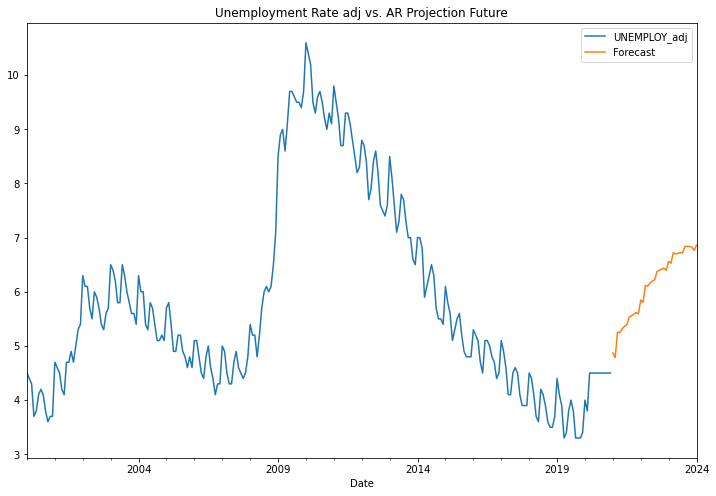

In [103]:
df[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. AR Projection Future')
forcasted_values.plot(legend=True)
plt.show()

In [104]:
#Descriptive statistics and tests

In [105]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [106]:
dftest=adfuller(df[target_index])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

In [107]:
for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

ADF test statistic       -3.125848
p-value                   0.024699
# lags used              12.000000
# observations          239.000000
critical value (1%)      -3.458011
critical value (5%)      -2.873710
critical value (10%)     -2.573256
dtype: float64


In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
adf_test(df[target_index])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.125848
p-value                   0.024699
# lags used              12.000000
# observations          239.000000
critical value (1%)      -3.458011
critical value (5%)      -2.873710
critical value (10%)     -2.573256
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


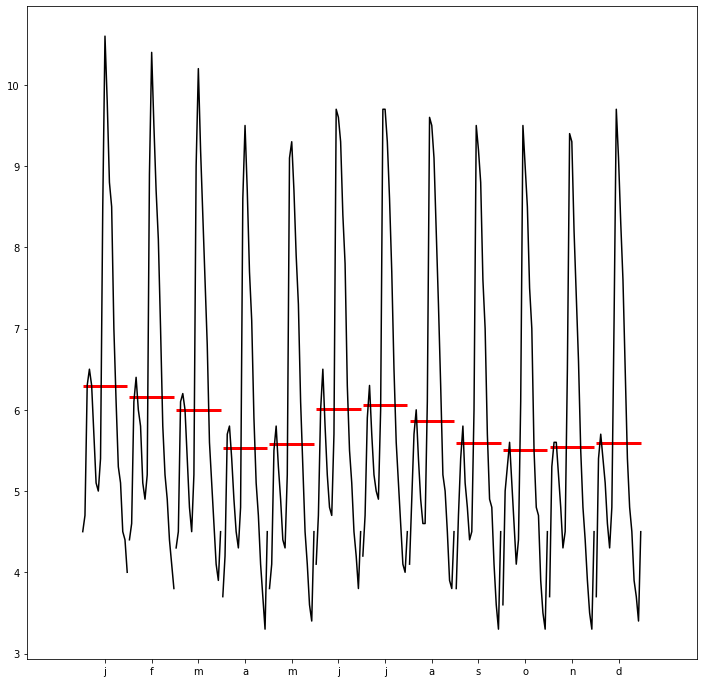

In [110]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(df[target_index]);

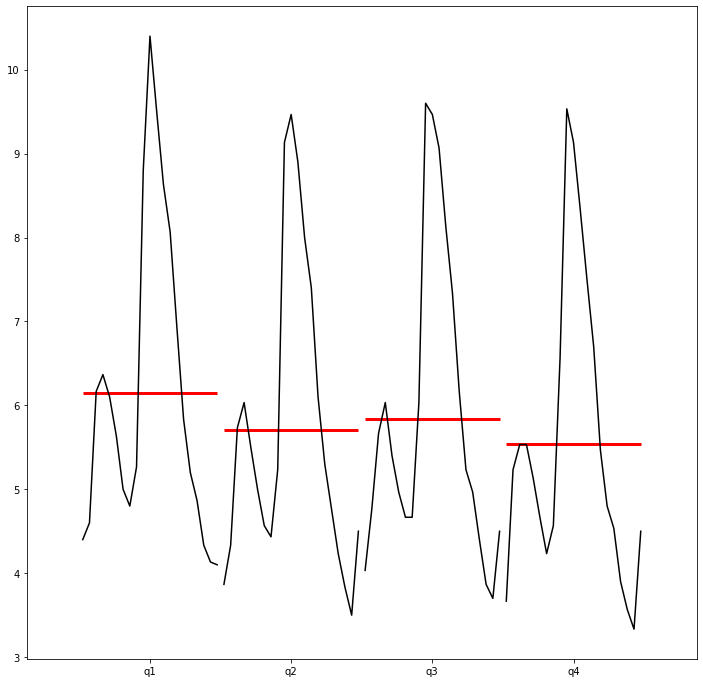

In [111]:
dfq = df[target_index].resample(rule='Q').mean()
quarter_plot(dfq);

In [112]:
#ARIMA orders

In [113]:
from pmdarima import auto_arima

In [114]:
stepwise_fit=auto_arima(df[target_index],start_p=0, start_q=0, max_p=6, max_q=3, seasonal = False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.187, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.746, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=187.374, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.187, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=194.961, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=185.975, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=181.615, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=154.100, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=152.208, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=150.211, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=183.975, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=152.103, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=179.615, Time=0.04 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Tota

In [115]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 -71.105
Date:                Mon, 27 Sep 2021   AIC                            150.211
Time:                        19:07:33   BIC                            164.313
Sample:                             0   HQIC                           155.886
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1198      0.058      2.062      0.039       0.006       0.234
ma.L2          0.0789      0.061      1.293      0.196      -0.041       0.199
ma.L3         -0.3795      0.074     -5.156      0.000      -0.524      -0.235
sigma2         0.1030      0.008     13.123      0.000       0.088       0.118
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                57.09
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.01
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [118]:
#ARMA

In [119]:
auto_arima(df[target_index], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(2, 1, 5)   Log Likelihood                 -25.125
Date:                Mon, 27 Sep 2021   AIC                             68.249
Time:                        19:07:37   BIC                             99.978
Sample:                             0   HQIC                            81.018
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.020     -0.116      0.908      -0.042       0.038
ar.L1          1.0004      0.006    160.550      0.000       0.988       1.013
ar.L2         -0.9938      0.006   -173.620      0.000      -1.005      -0.983
ma.L1         -1.1190      0.059    -19.029      0.000      -1.234      -1.004
ma.L2          1.1058      0.104     10.633      0.000       0.902       1.310
ma.L3         -0.0341      0.130     -0.261      0.794      -0.290       0.222
ma.L4         -0.0507      0.112     -0.454      0.650      -0.270       0.168
ma.L5          0.1047      0.064      1.624      0.104      -0.022       0.231
sigma2         0.0718      0.006     11.737      0.000       0.060       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                61.01
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.78
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
train = df.iloc[:200]
test = df.iloc[200:]

In [121]:
model=ARMA(train[target_index], order=(0,1,2))

In [122]:
results=model.fit()

In [123]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           UNEMPLOY_adj   No. Observations:                  200
Model:                     ARMA(0, 1)   Log Likelihood                -286.317
Method:                       css-mle   S.D. of innovations              1.009
Date:                Mon, 27 Sep 2021   AIC                            578.634
Time:                        19:07:37   BIC                            588.529
Sample:                    01-01-2000   HQIC                           582.639
                         - 08-01-2016                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.2442      0.132     47.176      0.000       5.985       6.504
ma.L1.UNEMPLOY_adj     0.8588      0.022     38.688      0.000       0.815       0.902
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.1644           +0.0000j            1.1644            0.5000
-----------------------------------------------------------------------------
"""

In [124]:
start=len(train)

In [125]:
end=len(train) +len(test)-1

In [126]:
predictions = results.predict(start,end,typ='levels').rename('ARMA (0,1) Prediction')

In [127]:
error=rmse(test[target_index],predictions)

In [128]:
error

2.1683381308993237

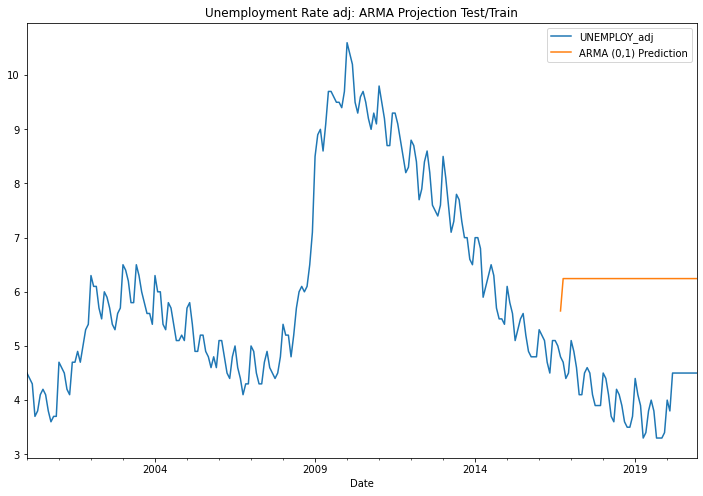

In [129]:
df[target_index].plot(figsize=(12,8), legend=True, title=index_title + ': ARMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [130]:
#ARIMA

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose

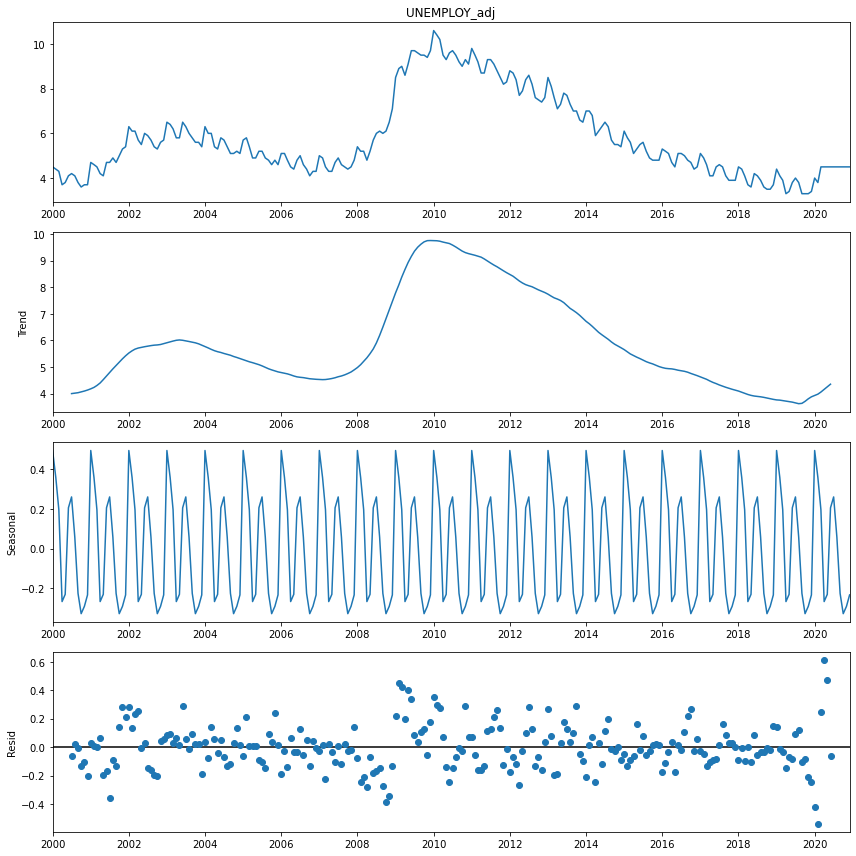

In [132]:
result = seasonal_decompose(df[target_index], model ='add')
result.plot();

In [133]:
auto_arima(df[target_index],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(2, 1, 5)   Log Likelihood                 -25.125
Date:                Mon, 27 Sep 2021   AIC                             68.249
Time:                        19:07:42   BIC                             99.978
Sample:                             0   HQIC                            81.018
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.020     -0.116      0.908      -0.042       0.038
ar.L1          1.0004      0.006    160.550      0.000       0.988       1.013
ar.L2         -0.9938      0.006   -173.620      0.000      -1.005      -0.983
ma.L1         -1.1190      0.059    -19.029      0.000      -1.234      -1.004
ma.L2          1.1058      0.104     10.633      0.000       0.902       1.310
ma.L3         -0.0341      0.130     -0.261      0.794      -0.290       0.222
ma.L4         -0.0507      0.112     -0.454      0.650      -0.270       0.168
ma.L5          0.1047      0.064      1.624      0.104      -0.022       0.231
sigma2         0.0718      0.006     11.737      0.000       0.060       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                61.01
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.78
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
df['Diff_1'] =diff(df[target_index], k_diff=2)

In [135]:
adf_test(df['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.264186e+01
p-value                 1.429197e-23
# lags used             1.000000e+01
# observations          2.390000e+02
critical value (1%)    -3.458011e+00
critical value (5%)    -2.873710e+00
critical value (10%)   -2.573256e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


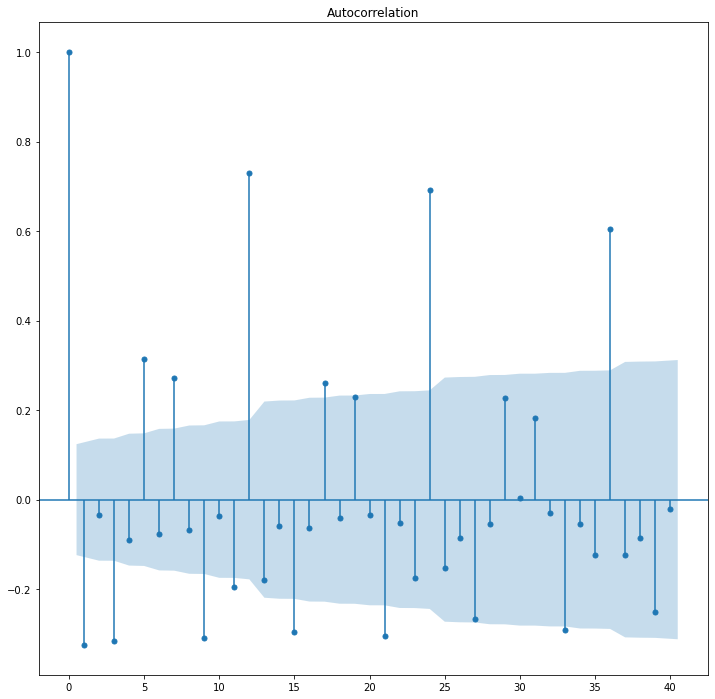

In [136]:
plot_acf(df['Diff_1'].dropna(),lags=40);

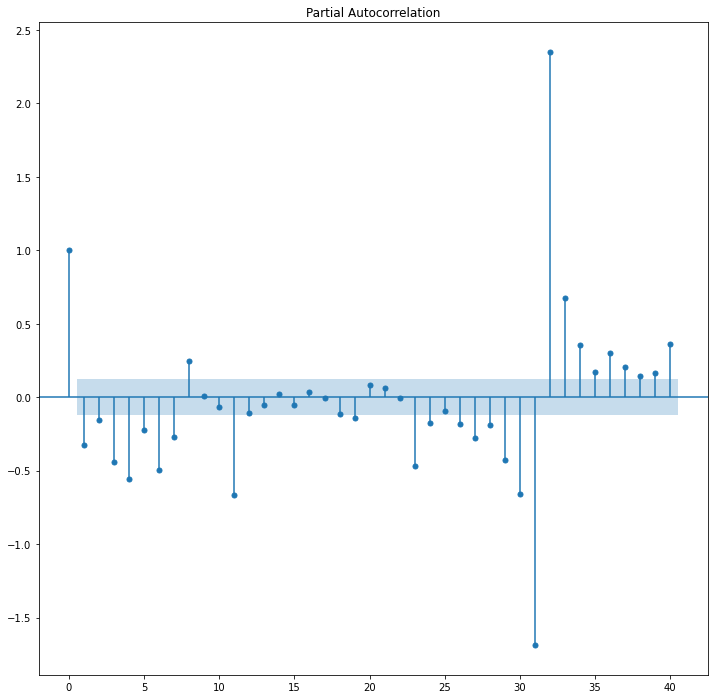

In [137]:
plot_pacf(df['Diff_1'].dropna(),lags=40);

In [138]:
stepwise_fit=auto_arima(df[target_index], start_p=0, start_q=0, max_p=12, max_q=12,
                       seasonal = False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.187, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.746, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=187.374, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.187, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=194.961, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=185.975, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=181.615, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=154.100, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=152.208, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=153.672, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=133.955, Time=0.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=120.236, Time=0.32 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=123.775, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(2, 1, 5)   Log Likelihood                 -25.125
Date:                Mon, 27 Sep 2021   AIC                             68.249
Time:                        19:07:48   BIC                             99.978
Sample:                             0   HQIC                            81.018
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0024      0.020     -0.116      0.908      -0.042       0.038
ar.L1          1.0004      0.006    160.550      0.000       0.988       1.013
ar.L2         -0.9938      0.006   -173.620      0.000      -1.005      -0.983
ma.L1         -1.1190      0.059    -19.029      0.000      -1.234      -1.004
ma.L2          1.1058      0.104     10.633      0.000       0.902       1.310
ma.L3         -0.0341      0.130     -0.261      0.794      -0.290       0.222
ma.L4         -0.0507      0.112     -0.454      0.650      -0.270       0.168
ma.L5          0.1047      0.064      1.624      0.104      -0.022       0.231
sigma2         0.0718      0.006     11.737      0.000       0.060       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                61.01
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.78
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
train = df.iloc[:200]
test = df.iloc[200:]

In [140]:
model=ARIMA(train[target_index], order=(4,1,4))

In [141]:
results=model.fit()

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.UNEMPLOY_adj   No. Observations:                  199
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 -22.692
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 27 Sep 2021   AIC                             65.384
Time:                        19:07:49   BIC                             98.317
Sample:                    02-01-2000   HQIC                            78.712
                         - 08-01-2016                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0185        nan        nan        nan         nan         nan
ar.L1.D.UNEMPLOY_adj    -0.6065        nan        nan        nan         nan         nan
ar.L2.D.UNEMPLOY_adj    -0.3540   4.26e-07  -8.31e+05      0.000      -0.354      -0.354
ar.L3.D.UNEMPLOY_adj    -0.6557        nan        nan        nan         nan         nan
ar.L4.D.UNEMPLOY_adj    -0.9506        nan        nan        nan         nan         nan
ma.L1.D.UNEMPLOY_adj     0.5762      0.007     83.271      0.000       0.563       0.590
ma.L2.D.UNEMPLOY_adj     0.4189      0.010     43.241      0.000       0.400       0.438
ma.L3.D.UNEMPLOY_adj     0.5762      0.012     47.509      0.000       0.552       0.600
ma.L4.D.UNEMPLOY_adj     1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4981           -0.8671j            1.0000           -0.1670
AR.2            0.4981           +0.8671j            1.0000            0.1670
AR.3           -0.8430           -0.5842j            1.0257           -0.4035
AR.4           -0.8430           +0.5842j            1.0257            0.4035
MA.1            0.5010           -0.8655j            1.0000           -0.1665
MA.2            0.5010           +0.8655j            1.0000            0.1665
MA.3           -0.7890           -0.6143j            1.0000           -0.3947
MA.4           -0.7890           +0.6143j            1.0000            0.3947
-----------------------------------------------------------------------------
"""

In [143]:
start=len(train)

In [144]:
end=len(train) +len(test)-1

In [145]:
predictions = results.predict(start,end, typ='levels').rename('ARIMA (0,1,2) Prediction')

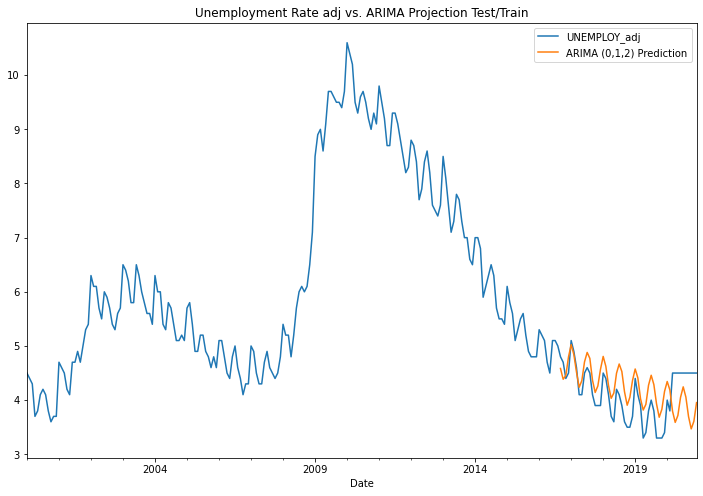

In [146]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [147]:
error=rmse(test[target_index],predictions)

In [148]:
error

0.48168046567939155

In [149]:
#FORECAST

In [150]:
model=ARIMA(df[target_index], order=(4,1,4))

In [151]:
results=model.fit()

In [152]:
fcast=results.predict(start=len(df), end=len(df)+24,typ='levels').rename('ARIMA(0,1,2)')

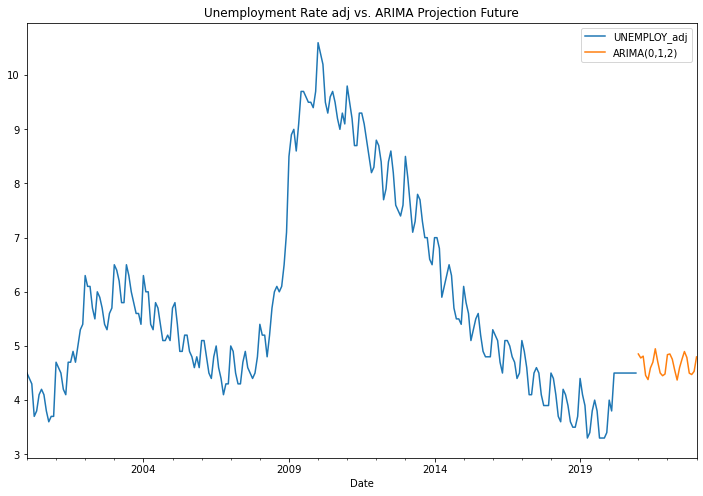

In [153]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Future')
fcast.plot(legend=True);

In [154]:
#SARIMA Models

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [157]:
auto_arima(df[target_index], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                  56.595
Date:                            Mon, 27 Sep 2021   AIC                           -101.190
Time:                                    19:08:29   BIC                            -80.037
Sample:                                         0   HQIC                           -92.677
                                            - 252                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9291      0.051     18.273      0.000       0.829       1.029
ma.L1         -0.8157      0.076    -10.691      0.000      -0.965      -0.666
ar.S.L12       1.0217      0.097     10.554      0.000       0.832       1.211
ar.S.L24      -0.0242      0.095     -0.254      0.799      -0.211       0.162
ma.S.L12      -0.8783      0.076    -11.553      0.000      -1.027      -0.729
sigma2         0.0329      0.002     15.816      0.000       0.029       0.037
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                78.70
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.58
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
train = df.iloc[:200]
test = df.iloc[200:]

In [159]:
model=SARIMAX(df[target_index], order=(1,1,1), seasonal_order=(1,1,1,12))

In [160]:
results=model.fit()

In [161]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       UNEMPLOY_adj   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  60.280
Date:                            Mon, 27 Sep 2021   AIC                           -110.561
Time:                                    19:08:30   BIC                            -93.178
Sample:                                01-01-2000   HQIC                          -103.556
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9418      0.045     20.994      0.000       0.854       1.030
ma.L1         -0.8240      0.068    -12.101      0.000      -0.957      -0.691
ar.S.L12       0.0250      0.094      0.265      0.791      -0.160       0.209
ma.S.L12      -0.8933      0.076    -11.779      0.000      -1.042      -0.745
sigma2         0.0328      0.002     15.379      0.000       0.029       0.037
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                71.58
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
start=len(train)

In [163]:
end=len(train) +len(test)-1

In [164]:
predictions=results.predict(start, end,typ='levels').rename('SARIMA Predictions')

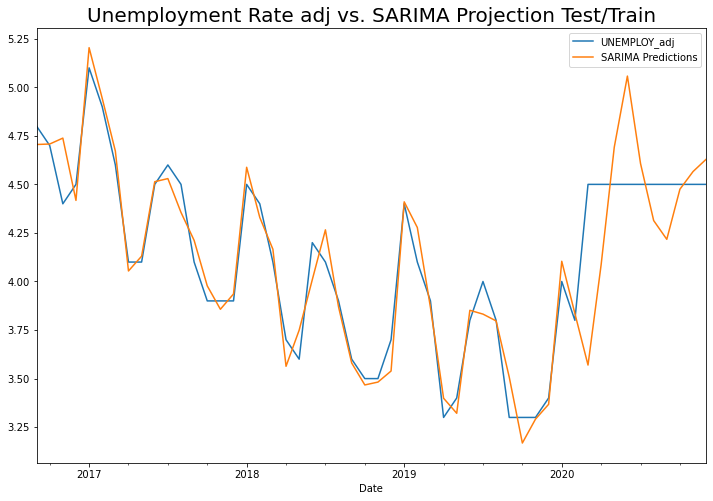

In [165]:
test[target_index].plot(legend=True, figsize=(12,8))
plt.title(index_title + ' vs. SARIMA Projection Test/Train', fontdict = {'fontsize' : 20})
predictions.plot(legend=True)
plt.savefig('image1.jpg');

In [166]:
error

0.48168046567939155

In [167]:
#Forecast

In [168]:
model= SARIMAX(df[target_index], order=(1,1,1), seasonal_order=(1,1,1,12))
results=model.fit()

In [169]:
fcast= results.predict(start=len(df), end=len(df)+35,typ='levels').rename('SARIMA FORECAST')

In [170]:
len(fcast)

36

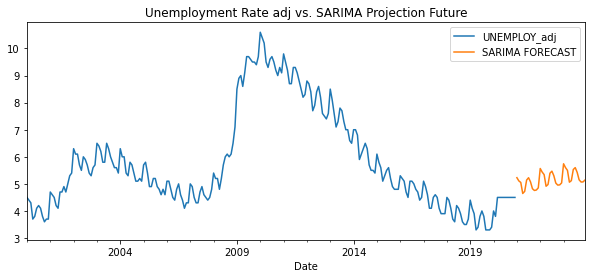

In [171]:
df[target_index].plot(legend=True, figsize=(10,4),title=index_title + ' vs. SARIMA Projection Future')
fcast.plot(legend=True);

In [172]:
fcast

2021-01-01    5.228792
2021-02-01    5.110070
2021-03-01    5.051625
2021-04-01    4.645874
2021-05-01    4.721553
2021-06-01    5.141460
2021-07-01    5.227574
2021-08-01    5.073492
2021-09-01    4.820799
2021-10-01    4.756624
2021-11-01    4.773327
2021-12-01    4.853501
2022-01-01    5.568251
2022-02-01    5.435306
2022-03-01    5.342611
2022-04-01    4.912311
2022-05-01    4.976303
2022-06-01    5.393910
2022-07-01    5.470132
2022-08-01    5.300861
2022-09-01    5.031175
2022-10-01    4.955339
2022-11-01    4.962984
2022-12-01    5.036238
2023-01-01    5.742235
2023-02-01    5.601020
2023-03-01    5.500017
2023-04-01    5.062084
2023-05-01    5.119173
2023-06-01    5.530496
2023-07-01    5.600608
2023-08-01    5.425435
2023-09-01    5.150124
2023-10-01    5.069098
2023-11-01    5.071904
2023-12-01    5.140641
Freq: MS, Name: SARIMA FORECAST, dtype: float64

In [173]:
### Auto-ARIMA

In [174]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df[target_index], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=194.961, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.187, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.746, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=187.374, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.187, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=185.975, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=181.615, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=154.100, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=152.208, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=153.672, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=133.955, Time=0.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=120.236, Time=0.32 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=123.775, Time

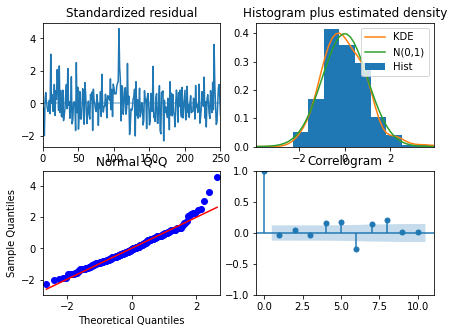

In [175]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [176]:
df[target_index]

Date
2000-01-01    4.5
2000-02-01    4.4
2000-03-01    4.3
2000-04-01    3.7
2000-05-01    3.8
             ... 
2020-08-01    4.5
2020-09-01    4.5
2020-10-01    4.5
2020-11-01    4.5
2020-12-01    4.5
Freq: MS, Name: UNEMPLOY_adj, Length: 252, dtype: float64

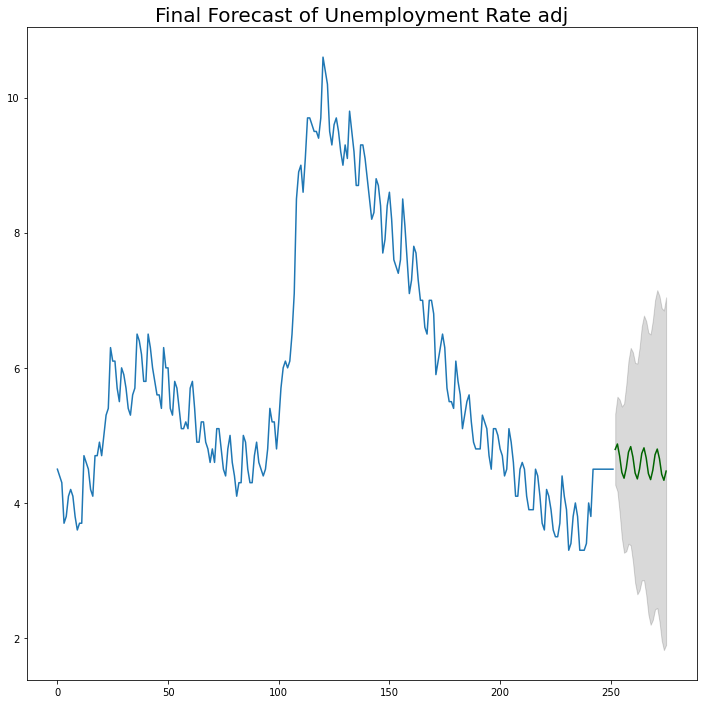

In [177]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df[target_index]), len(df[target_index])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

df.reset_index(inplace=True)

# Plot
plt.plot(df[target_index])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of " + index_title, fontdict = {'fontsize' : 20})
plt.savefig('image2.jpg');

In [178]:
fc_series.to_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/UNEMPLOY_adj', header=False)

In [179]:
###Keras

In [180]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [181]:
from keras.models import Sequential
from keras.layers import Dense

In [182]:
model = Sequential()
# 4 Neurons, expecting only 1 feature with input_dim=1
model.add(Dense(4, input_dim=1, activation='relu'))
# 4 Neurons (Play around with this number!)
model.add(Dense(4, activation='relu'))
# One final output of y, so only 1 neuron
model.add(Dense(1, activation='linear'))
# Compil the layers
model.compile(loss='mse', optimizer='adam')

In [183]:
df=df.reset_index()

In [184]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.fit(df.index, df[target_index], epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 0s 1ms/step - loss: 48.9243
Epoch 2/500
8/8 [==============================] - 0s 1ms/step - loss: 44.1448
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 40.2634
Epoch 4/500
8/8 [==============================] - 0s 997us/step - loss: 37.2421
Epoch 5/500
8/8 [==============================] - 0s 990us/step - loss: 36.6434
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 36.5565
Epoch 7/500
8/8 [==============================] - 0s 1ms/step - loss: 36.4672
Epoch 8/500
8/8 [==============================] - 0s 997us/step - loss: 36.3809
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 36.2916
Epoch 10/500
8/8 [==============================] - 0s 997us/step - loss: 36.2039
Epoch 11/500
8/8 [==============================] - 0s 1ms/step - loss: 36.1156
Epoch 12/500
8/8 [==============================] - 0s 1ms/step - loss: 36.0272
Epoch 13/500
8/8 [=======================

8/8 [==============================] - 0s 1ms/step - loss: 28.8434
Epoch 100/500
8/8 [==============================] - 0s 1ms/step - loss: 28.7682
Epoch 101/500
8/8 [==============================] - 0s 1ms/step - loss: 28.6925
Epoch 102/500
8/8 [==============================] - 0s 1ms/step - loss: 28.6168
Epoch 103/500
8/8 [==============================] - 0s 1ms/step - loss: 28.5416
Epoch 104/500
8/8 [==============================] - 0s 936us/step - loss: 28.4673
Epoch 105/500
8/8 [==============================] - 0s 1ms/step - loss: 28.3912
Epoch 106/500
8/8 [==============================] - 0s 1ms/step - loss: 28.3173
Epoch 107/500
8/8 [==============================] - 0s 1ms/step - loss: 28.2432
Epoch 108/500
8/8 [==============================] - 0s 1ms/step - loss: 28.1681
Epoch 109/500
8/8 [==============================] - 0s 1ms/step - loss: 28.0936
Epoch 110/500
8/8 [==============================] - 0s 1ms/step - loss: 28.0201
Epoch 111/500
8/8 [=====================

8/8 [==============================] - 0s 1ms/step - loss: 22.0099
Epoch 200/500
8/8 [==============================] - 0s 997us/step - loss: 21.9479
Epoch 201/500
8/8 [==============================] - 0s 986us/step - loss: 21.8878
Epoch 202/500
8/8 [==============================] - 0s 976us/step - loss: 21.8270
Epoch 203/500
8/8 [==============================] - 0s 1ms/step - loss: 21.7660
Epoch 204/500
8/8 [==============================] - 0s 1ms/step - loss: 21.7054
Epoch 205/500
8/8 [==============================] - 0s 1ms/step - loss: 21.6446
Epoch 206/500
8/8 [==============================] - 0s 1ms/step - loss: 21.5835
Epoch 207/500
8/8 [==============================] - 0s 1ms/step - loss: 21.5242
Epoch 208/500
8/8 [==============================] - 0s 983us/step - loss: 21.4641
Epoch 209/500
8/8 [==============================] - 0s 1ms/step - loss: 21.4042
Epoch 210/500
8/8 [==============================] - 0s 997us/step - loss: 21.3440
Epoch 211/500
8/8 [=============

8/8 [==============================] - 0s 1ms/step - loss: 16.5198
Epoch 300/500
8/8 [==============================] - 0s 1ms/step - loss: 16.4707
Epoch 301/500
8/8 [==============================] - 0s 1ms/step - loss: 16.4227
Epoch 302/500
8/8 [==============================] - 0s 1ms/step - loss: 16.3738
Epoch 303/500
8/8 [==============================] - 0s 1ms/step - loss: 16.3253
Epoch 304/500
8/8 [==============================] - 0s 1ms/step - loss: 16.2771
Epoch 305/500
8/8 [==============================] - 0s 937us/step - loss: 16.2290
Epoch 306/500
8/8 [==============================] - 0s 1ms/step - loss: 16.1813
Epoch 307/500
8/8 [==============================] - 0s 1ms/step - loss: 16.1333
Epoch 308/500
8/8 [==============================] - 0s 1ms/step - loss: 16.0854
Epoch 309/500
8/8 [==============================] - 0s 1ms/step - loss: 16.0374
Epoch 310/500
8/8 [==============================] - 0s 1ms/step - loss: 15.9903
Epoch 311/500
8/8 [=====================

8/8 [==============================] - 0s 1ms/step - loss: 12.1967
Epoch 400/500
8/8 [==============================] - 0s 1ms/step - loss: 12.1592
Epoch 401/500
8/8 [==============================] - 0s 997us/step - loss: 12.1212
Epoch 402/500
8/8 [==============================] - 0s 1ms/step - loss: 12.0838
Epoch 403/500
8/8 [==============================] - 0s 1ms/step - loss: 12.0459
Epoch 404/500
8/8 [==============================] - 0s 1ms/step - loss: 12.0088
Epoch 405/500
8/8 [==============================] - 0s 1ms/step - loss: 11.9717
Epoch 406/500
8/8 [==============================] - 0s 1ms/step - loss: 11.9345
Epoch 407/500
8/8 [==============================] - 0s 1ms/step - loss: 11.8972
Epoch 408/500
8/8 [==============================] - 0s 1ms/step - loss: 11.8602
Epoch 409/500
8/8 [==============================] - 0s 1ms/step - loss: 11.8235
Epoch 410/500
8/8 [==============================] - 0s 1ms/step - loss: 11.7868
Epoch 411/500
8/8 [=====================

8/8 [==============================] - 0s 712us/step - loss: 8.9022
Epoch 500/500
8/8 [==============================] - 0s 571us/step - loss: 8.8752


In [186]:
x_for_predictions = np.linspace(0,252,1000)

In [187]:
y_predicted = model.predict(x_for_predictions)

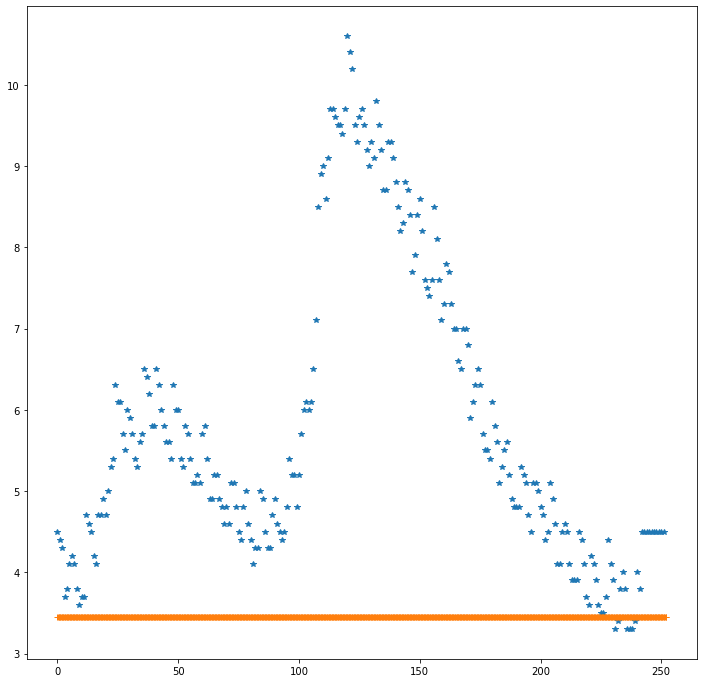

In [188]:
# Original X and Y
plt.plot(df.index, df[target_index],'*')
# Our Model's prediction Line
plt.plot(x_for_predictions,y_predicted,'+')

In [189]:
# start full Keras

In [190]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [191]:
df=df.reset_index()

In [192]:
df.drop(labels=(['Date','Unnamed: 0','Y30_fixed_mortgage_rate','CS_HPA_20_cities','LF_Part','CS_HP','Y10_CMT', 'UNEMPLOY','LF_Part_adj']),axis=1,inplace=True)

In [193]:
train_len = len(df)-36

In [194]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [195]:
from sklearn.preprocessing import MinMaxScaler

In [196]:
scaler = MinMaxScaler()

In [197]:
scaler.fit(train)

MinMaxScaler()

In [198]:
scaled_train = scaler.transform(train)

In [199]:
scaled_test = scaler.transform(test)

In [200]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [201]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [202]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [203]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [204]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [205]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
204/204 [==============================] - 1s 2ms/step - loss: 0.0185
Epoch 2/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 3/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 4/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 5/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 6/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 7/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 9/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 10/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 12/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 13/30
204/204 [====

In [206]:
model.history.history.keys()

dict_keys(['loss'])

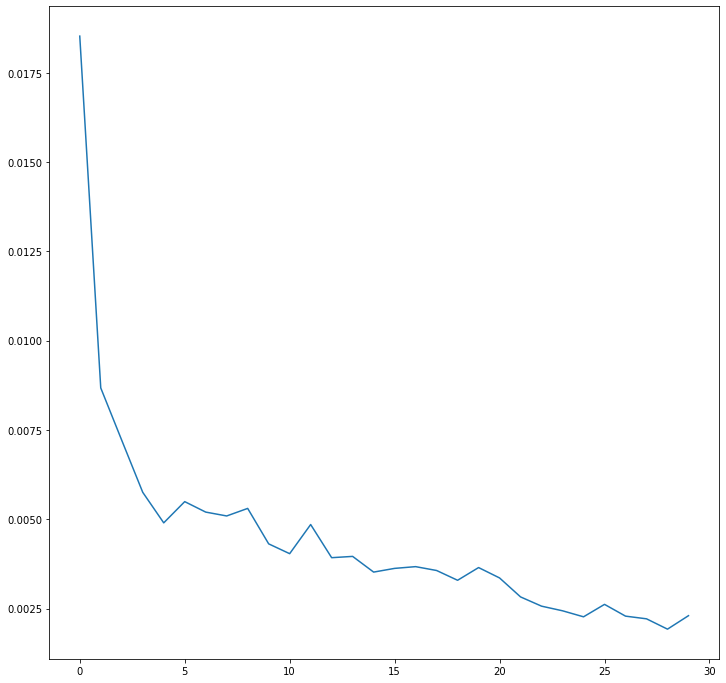

In [207]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.show()

In [208]:
first_eval_batch = scaled_train[-12:]

In [209]:
first_eval_batch

array([[0.21428571],
       [0.18571429],
       [0.14285714],
       [0.07142857],
       [0.07142857],
       [0.12857143],
       [0.14285714],
       [0.12857143],
       [0.07142857],
       [0.04285714],
       [0.04285714],
       [0.04285714]])

In [210]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [211]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [212]:
true_predictions = scaler.inverse_transform(test_predictions)

In [213]:
true_predictions

array([[4.31935699],
       [4.27614657],
       [4.15467542],
       [4.12360834],
       [4.15746128],
       [4.29678862],
       [4.63142443],
       [4.81380104],
       [4.74961545],
       [4.71829579],
       [4.79011663],
       [5.09289757],
       [5.44785166],
       [5.55089537],
       [5.46889499],
       [5.4128325 ],
       [5.48190848],
       [5.75489703],
       [6.05955208],
       [6.02478243],
       [5.80329621],
       [5.63854653],
       [5.65721748],
       [5.82800097],
       [6.05800936],
       [5.84287531],
       [5.5503611 ],
       [5.31284711],
       [5.26382793],
       [5.35636676],
       [5.53852213],
       [5.27880209],
       [4.98451329],
       [4.76265887],
       [4.70084514],
       [4.7729593 ]])

In [214]:
test['Predictions'] = true_predictions

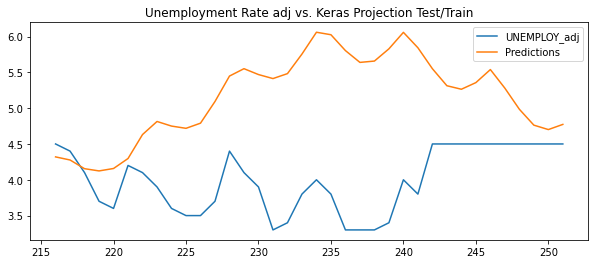

In [215]:
test.plot(figsize=(10,4),title=index_title + ' vs. Keras Projection Test/Train')
plt.show()

In [216]:
error=rmse(test[target_index],test['Predictions'])

In [217]:
print(error)

1.4174947330913916


In [218]:
### Keras projection

In [219]:
train_len = len(df)

In [220]:
train = df.iloc[:train_len]

In [221]:
scaler.fit(train)

MinMaxScaler()

In [222]:
scaled_train = scaler.transform(train)

In [223]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [224]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [225]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [226]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0137
Epoch 2/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 3/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 4/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0051A: 0s - los
Epoch 5/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 6/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0045
Epoch 7/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 8/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 9/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 10/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 11/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0039
Epoch 12/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0036
Epoch 13/30
24

In [227]:
model.history.history.keys()

dict_keys(['loss'])

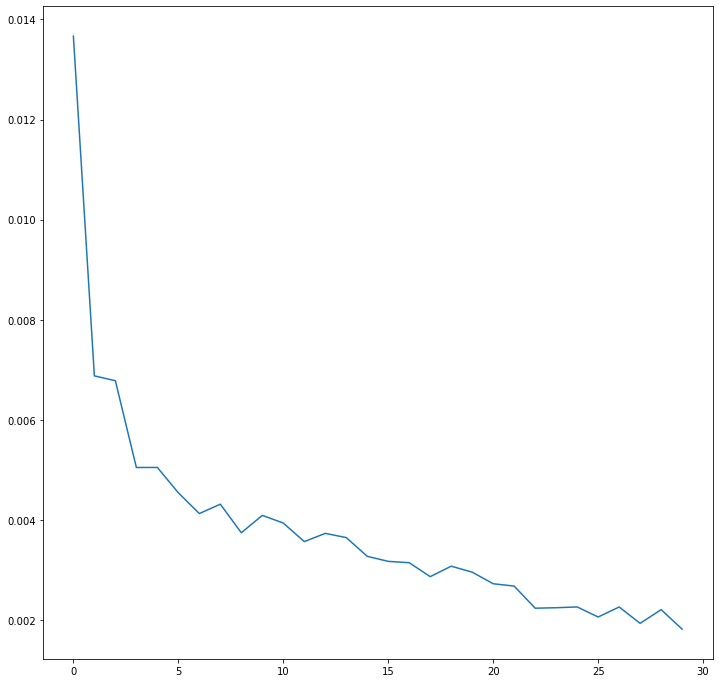

In [228]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [229]:
first_eval_batch = scaled_train[-12:]

In [230]:
first_eval_batch

array([[0.09589041],
       [0.06849315],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356],
       [0.16438356]])

In [231]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [232]:
future_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(36):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    future_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [233]:
true_predictions = scaler.inverse_transform(test_predictions)

In [234]:
projections=pd.DataFrame(true_predictions)

In [235]:
projections.index = np.arange(252, 252+36)

In [236]:
projections=projections.rename(columns={0: 'UNEMPLOY_adj:Proj.'})

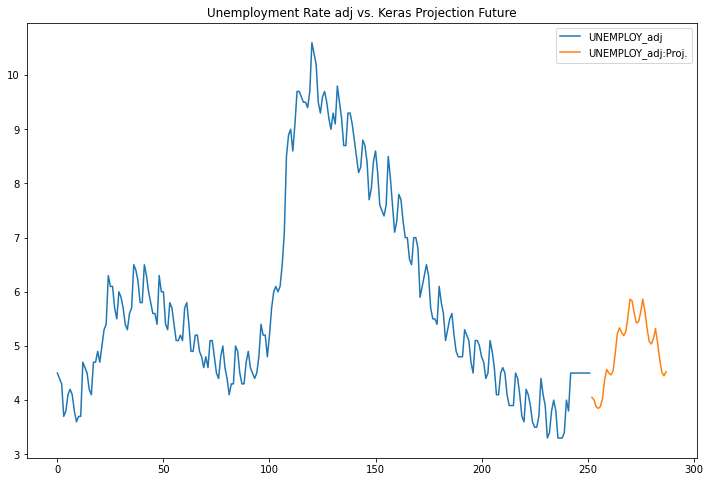

In [237]:
train[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. Keras Projection Future')
projections['UNEMPLOY_adj:Proj.'].plot(legend=True)
plt.show()